# Water Bodies Segmentation

Water Segmentation Model Pipeline
Robust solution for water body segmentation using U-Net architecture

## 1. Environment Setup

In [165]:
# Core libraries
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import re
import pickle

In [166]:
# Image processing
import tifffile as tiff
from PIL import Image
import cv2

In [167]:
# Machine learning
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [195]:
# TensorFlow/Keras
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Conv2DTranspose, BatchNormalization,
    concatenate, Dropout
)

In [169]:
print("Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")

Libraries imported successfully!
TensorFlow version: 2.18.0


---

## 2. Google Drive Setup

In [170]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [171]:
# Define paths
DRIVE_PATH = "/content/drive/MyDrive/Datasets"
ZIP_PATH = os.path.join(DRIVE_PATH, "data.zip")
EXTRACT_PATH = os.path.join(DRIVE_PATH, "Extracted Data")
DATA_PATH = os.path.join(EXTRACT_PATH, "data")

In [172]:
# Create extraction directory
os.makedirs(EXTRACT_PATH, exist_ok=True)

In [173]:
# Extract dataset
if os.path.exists(ZIP_PATH):
    print("Extracting dataset...")
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_PATH)
    print("Dataset extracted successfully!")
else:
    print(f"Zip file not found at {ZIP_PATH}")

Extracting dataset...
Dataset extracted successfully!


---

## 3. Data Handler Class

In [174]:
class WaterSegmentationDataHandler:
    """Handles data loading, preprocessing, and splitting for water segmentation"""

    def __init__(self, data_path):
        self.data_path = data_path
        self.images_dir = os.path.join(data_path, "images")
        self.labels_dir = os.path.join(data_path, "labels")
        self.input_images = []
        self.segmentation_labels = []
        self.scaled_input_images = []

    def natural_key(self, file_name):
        """Natural sorting key for filenames with numbers"""
        return [int(text) if text.isdigit() else text for text in re.split(r'(\d+)', file_name)]

    def load_tiff_images(self, directory):
        """Load TIFF images from directory"""
        images = []
        if not os.path.exists(directory):
            print(f"Directory not found: {directory}")
            return images

        tiff_files = sorted([f for f in os.listdir(directory)
                            if f.endswith(('.tif', '.tiff'))], key=self.natural_key)

        print(f"Found {len(tiff_files)} TIFF files")

        for filename in tiff_files:
            file_path = os.path.join(directory, filename)
            try:
                image = np.array(tiff.imread(file_path))
                images.append(image)
                print(f"Loaded: {filename} - Shape: {image.shape}")
            except Exception as e:
                print(f"Failed to load {filename}: {e}")

        return images

    def load_png_labels(self, directory):
        """Load PNG label images, filtering out files with underscores"""
        labels = []
        if not os.path.exists(directory):
            print(f"Directory not found: {directory}")
            return labels

        png_files = []
        for filename in os.listdir(directory):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                if "_" not in filename:
                    png_files.append(filename)
                else:
                    print(f"Skipping file with underscore: {filename}")

        png_files = sorted(png_files, key=self.natural_key)
        print(f"Found {len(png_files)} valid label files")

        for filename in png_files:
            file_path = os.path.join(directory, filename)
            try:
                image = Image.open(file_path)
                labels.append(np.array(image))
                print(f"Loaded: {filename} - Shape: {np.array(image).shape}")
            except Exception as e:
                print(f"Error processing {filename}: {e}")

        return labels

    def load_data(self):
        """Load input images and segmentation labels"""
        print("Loading input images...")
        self.input_images = self.load_tiff_images(self.images_dir)
        print(f"\nLoaded {len(self.input_images)} input images")

        print("\nLoading segmentation labels...")
        self.segmentation_labels = self.load_png_labels(self.labels_dir)
        print(f"\nLoaded {len(self.segmentation_labels)} label images")

        # Verify data consistency
        if len(self.input_images) != len(self.segmentation_labels):
            print(f"WARNING: Mismatch between images ({len(self.input_images)}) and labels ({len(self.segmentation_labels)})")
        else:
            print(f"✓ Data consistency check passed: {len(self.input_images)} image-label pairs")

        if self.input_images and self.segmentation_labels:
            print(f"\nSample input image shape: {self.input_images[0].shape}")
            print(f"Sample label image shape: {self.segmentation_labels[0].shape}")

    def normalize_images(self):
        """Normalize input images using MinMaxScaler"""
        normalized_images = []

        print("Normalizing images...")
        for i, image_array in enumerate(self.input_images):
            original_shape = image_array.shape
            reshaped_array = image_array.reshape(-1, original_shape[-1])

            scaler = MinMaxScaler()
            scaled_array = scaler.fit_transform(reshaped_array)
            normalized_image = scaled_array.reshape(original_shape)
            normalized_images.append(normalized_image)

            if i < 3:
                print(f"Image {i}: min={normalized_image.min():.3f}, max={normalized_image.max():.3f}")

        self.scaled_input_images = normalized_images
        print(f"✓ Normalized {len(self.scaled_input_images)} images")

    def split_dataset(self, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
        """Split dataset into train, validation, and test sets"""
        assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Ratios must sum to 1.0"

        def split_data(dataset):
            total_samples = len(dataset)
            train_len = int(total_samples * train_ratio)
            val_len = int(total_samples * val_ratio)

            train_data = dataset[:train_len]
            val_data = dataset[train_len:train_len + val_len]
            test_data = dataset[train_len + val_len:]

            return train_data, val_data, test_data

        print("Splitting dataset...")
        train_images, val_images, test_images = split_data(self.scaled_input_images)
        train_labels, val_labels, test_labels = split_data(self.segmentation_labels)

        print(f"Training set: {len(train_images)} samples")
        print(f"Validation set: {len(val_images)} samples")
        print(f"Test set: {len(test_images)} samples")

        return (train_images, val_images, test_images), (train_labels, val_labels, test_labels)

    def process_all(self):
        """Execute complete data processing pipeline"""
        self.load_data()
        self.normalize_images()
        return self.split_dataset()

---

## 4. Data Loading and Processing



In [175]:
# Initialize data handler
data_handler = WaterSegmentationDataHandler(DATA_PATH)

In [176]:
# Process all data
(train_images, val_images, test_images), (train_labels, val_labels, test_labels) = data_handler.process_all()

Loading input images...
Found 306 TIFF files
Loaded: 0.tif - Shape: (128, 128, 12)
Loaded: 1.tif - Shape: (128, 128, 12)
Loaded: 2.tif - Shape: (128, 128, 12)
Loaded: 3.tif - Shape: (128, 128, 12)
Loaded: 4.tif - Shape: (128, 128, 12)
Loaded: 5.tif - Shape: (128, 128, 12)
Loaded: 6.tif - Shape: (128, 128, 12)
Loaded: 7.tif - Shape: (128, 128, 12)
Loaded: 8.tif - Shape: (128, 128, 12)
Loaded: 9.tif - Shape: (128, 128, 12)
Loaded: 10.tif - Shape: (128, 128, 12)
Loaded: 11.tif - Shape: (128, 128, 12)
Loaded: 12.tif - Shape: (128, 128, 12)
Loaded: 13.tif - Shape: (128, 128, 12)
Loaded: 14.tif - Shape: (128, 128, 12)
Loaded: 15.tif - Shape: (128, 128, 12)
Loaded: 16.tif - Shape: (128, 128, 12)
Loaded: 17.tif - Shape: (128, 128, 12)
Loaded: 18.tif - Shape: (128, 128, 12)
Loaded: 19.tif - Shape: (128, 128, 12)
Loaded: 20.tif - Shape: (128, 128, 12)
Loaded: 21.tif - Shape: (128, 128, 12)
Loaded: 22.tif - Shape: (128, 128, 12)
Loaded: 23.tif - Shape: (128, 128, 12)
Loaded: 24.tif - Shape: (128,

In [177]:
# Convert to numpy arrays
X_train = np.array(train_images)
y_train = np.array(train_labels)
X_val = np.array(val_images)
y_val = np.array(val_labels)
X_test = np.array(test_images)
y_test = np.array(test_labels)

In [178]:
print(f"Training data shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Validation labels shape: {y_val.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Test labels shape: {y_test.shape}")

Training data shape: (244, 128, 128, 12)
Training labels shape: (244, 128, 128)
Validation data shape: (30, 128, 128, 12)
Validation labels shape: (30, 128, 128)
Test data shape: (32, 128, 128, 12)
Test labels shape: (32, 128, 128)


---

## 5. U-Net Model Architecture


In [196]:
def create_unet_model(input_height=128, input_width=128, input_channels=12):
    """Create U-Net model for binary segmentation with batch normalization"""

    inputs = Input((input_height, input_width, input_channels))

    # Encoder path
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Dropout(0.1)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(c3)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Dropout(0.1)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(c4)
    c4 = BatchNormalization()(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(p4)
    c5 = BatchNormalization()(c5)
    c5 = Dropout(0.1)(c5)
    c5 = Conv2D(128, (3, 3), activation='relu', padding='same')(c5)
    c5 = BatchNormalization()(c5)

    # Decoder path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Dropout(0.1)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(c6)
    c6 = BatchNormalization()(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Dropout(0.1)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(c7)
    c7 = BatchNormalization()(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', padding='same')(u8)
    c8 = BatchNormalization()(c8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', padding='same')(c8)
    c8 = BatchNormalization()(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(16, (3, 3), activation='relu', padding='same')(u9)
    c9 = BatchNormalization()(c9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', padding='same')(c9)
    c9 = BatchNormalization()(c9)

    # Output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

---

## 6. Model Creation and Training

In [197]:
# Create model
print("Creating U-Net model...")
if len(X_train) > 0:
    input_shape = X_train[0].shape
    model = create_unet_model(
        input_height=input_shape[0],
        input_width=input_shape[1],
        input_channels=input_shape[2]
    )

    print("✓ Model created successfully!")
    print(f"Input shape: {input_shape}")
    model.summary()
else:
    print("No training data available")

Creating U-Net model...
✓ Model created successfully!
Input shape: (128, 128, 12)


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_114 (Conv2D) │ (None, 128, 128,  │      1,744 │ input_layer_6[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │         64 │ conv2d_114[0][0]  │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_54          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_115 (Conv2D) │ (None, 128, 128,  │      2,320 │ dropout_54[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │         64 │ conv2d_115[0][0]  │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_24    │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_116 (Conv2D) │ (None, 64, 64,    │      4,640 │ max_pooling2d_24… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_116[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_55          │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_117 (Conv2D) │ (None, 64, 64,    │      9,248 │ dropout_55[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_117[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_25    │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_118 (Conv2D) │ (None, 32, 32,    │     18,496 │ max_pooling2d_25… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_118[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_56          │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_119 (Conv2D) │ (None, 32, 32,    │     36,928 │ dropout_56[0][0]

 Total params: 1,587,201 (6.05 MB)

 Trainable params: 1,584,513 (6.04 MB)

 Non-trainable params: 2,688 (10.50 KB)

In [198]:
# Train model
print("Starting model training...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=8,
    verbose=1
)

print("✓ Training completed!")

Starting model training...
Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 55s 718ms/step - accuracy: 0.6110 - loss: 0.7109 - val_accuracy: 0.8189 - val_loss: 0.4528
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.8541 - loss: 0.3779 - val_accuracy: 0.8125 - val_loss: 0.4894
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.8744 - loss: 0.3357 - val_accuracy: 0.7871 - val_loss: 0.5242
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.8796 - loss: 0.3170 - val_accuracy: 0.8178 - val_loss: 0.4886
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.8877 - loss: 0.2990 - val_accuracy: 0.9001 - val_loss: 0.3432
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8966 - loss: 0.2820 - val_accuracy: 0.8980 - val_loss: 0.2954
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9006 - loss: 0.2696 - val_accuracy: 0.9000 - val_loss: 0.2640
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9047 - lo

---

## 7. Model Evaluation


In [199]:
# Evaluate on test set
print("Evaluating model on test set...")
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)

print(f"✓ Test Loss: {test_loss:.4f}")
print(f"✓ Test Accuracy: {test_accuracy:.4f}")

Evaluating model on test set...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 930ms/step - accuracy: 0.9328 - loss: 0.2761
✓ Test Loss: 0.2761
✓ Test Accuracy: 0.9328


---

## 8. Predictions and Visualization


In [200]:
# Generate predictions
print("Generating predictions...")
predictions = model.predict(X_test)
print(f"Predictions shape: {predictions.shape}")

Generating predictions...


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predictions shape: (32, 128, 128, 1)


In [201]:
# Apply threshold
threshold = 0.2
binary_predictions = (predictions >= threshold).astype(np.uint8)
print(f"Applied threshold: {threshold}")

Applied threshold: 0.2


In [202]:
def display_results(image, true_mask, pred_mask, index=0):
    """Display input image, true mask, and predicted mask"""
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title(f"Input Image {index}")
    plt.imshow(image[:, :, :3])
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title(f"True Mask {index}")
    plt.imshow(true_mask.squeeze(), cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title(f"Predicted Mask {index}")
    plt.imshow(pred_mask.squeeze(), cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

Displaying sample predictions...


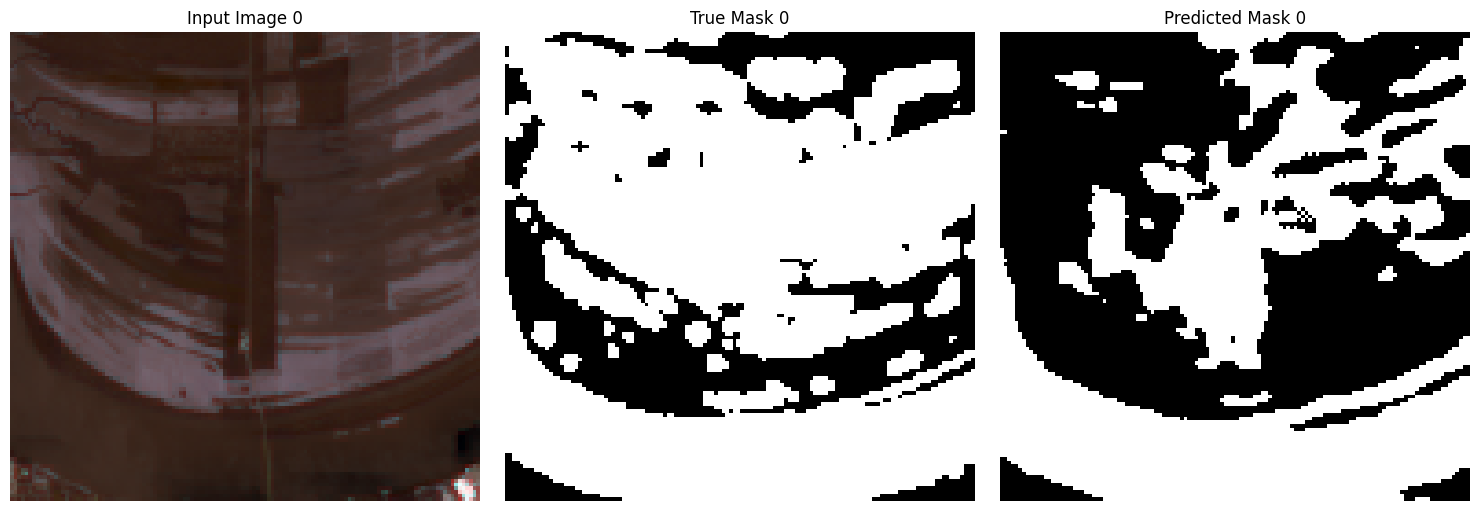

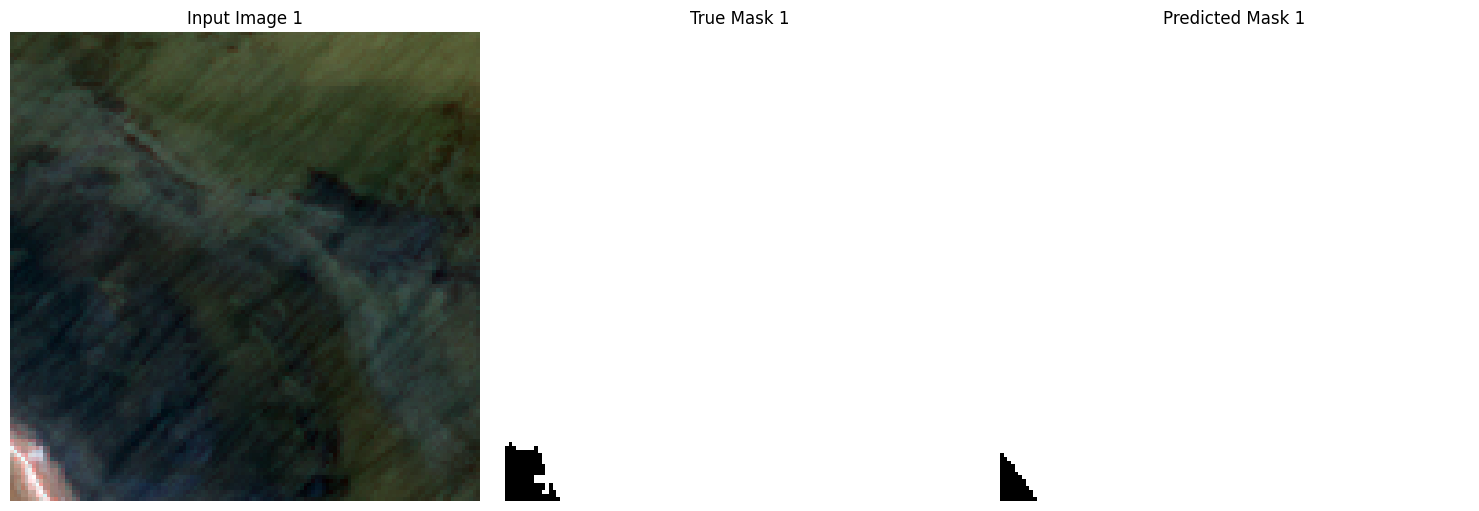

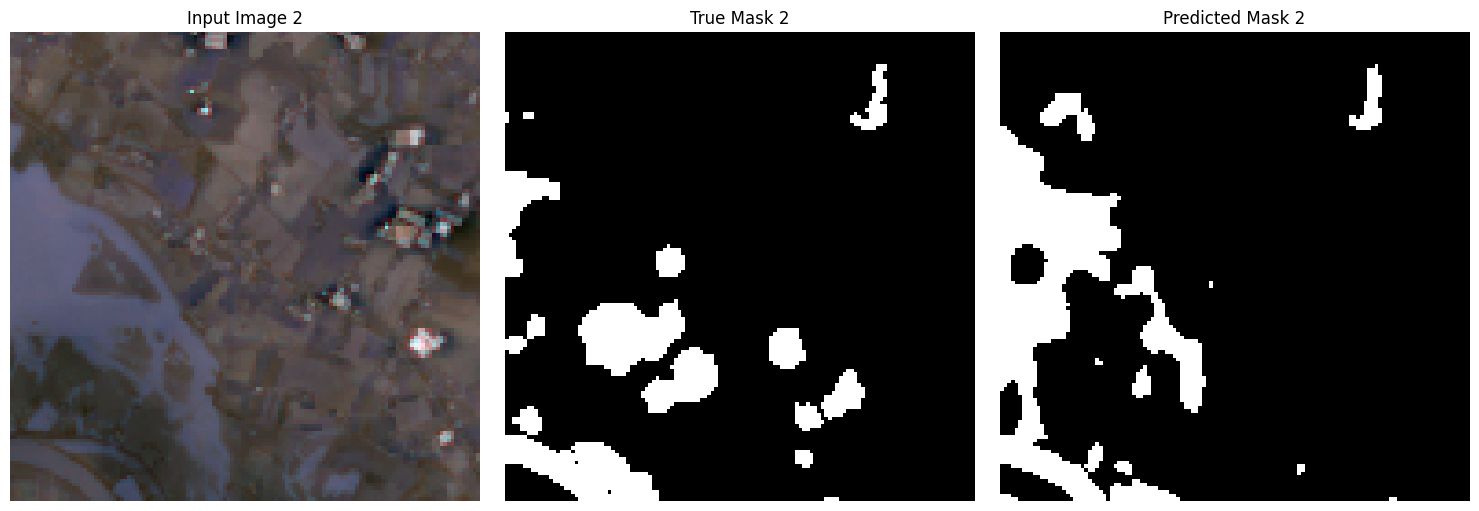

In [203]:
# Display sample results
print("Displaying sample predictions...")
for i in range(min(3, len(X_test))):
    display_results(X_test[i], y_test[i], binary_predictions[i], i)

---

## 9. Performance Metrics

In [204]:
# Calculate detailed metrics
y_true_flat = y_test.flatten()
y_pred_flat = binary_predictions.flatten()

print("Classification Report:")
print("=" * 50)
print(classification_report(y_true_flat, y_pred_flat))

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.95    365116
           1       0.93      0.85      0.89    159172

    accuracy                           0.94    524288
   macro avg       0.94      0.91      0.92    524288
weighted avg       0.94      0.94      0.93    524288



In [205]:
# Additional metrics
accuracy = accuracy_score(y_true_flat, y_pred_flat)
cm = confusion_matrix(y_true_flat, y_pred_flat)

print(f"\nPixel-wise Accuracy: {accuracy:.4f}")
print(f"Confusion Matrix:\n{cm}")


Pixel-wise Accuracy: 0.9357
Confusion Matrix:
[[355488   9628]
 [ 24082 135090]]


---

## 10. Save Model and Results

In [206]:
# Save model
model_save_path = os.path.join(DRIVE_PATH, "water_segmentation_model.h5")
model.save(model_save_path)
print(f"✓ Model saved to: {model_save_path}")

✓ Model saved to: /content/drive/MyDrive/Datasets/water_segmentation_model.h5


In [207]:
# Save training history
history_save_path = os.path.join(DRIVE_PATH, "training_history.pkl")
with open(history_save_path, 'wb') as f:
    pickle.dump(history.history, f)
print(f"✓ Training history saved to: {history_save_path}")

✓ Training history saved to: /content/drive/MyDrive/Datasets/training_history.pkl


---

In [208]:
print("\n" + "="*50)
print("WATER SEGMENTATION MODEL TRAINING COMPLETE!")
print("="*50)


WATER SEGMENTATION MODEL TRAINING COMPLETE!
